This project demonstrates A/B testing methods using play-by-play Major League Baseball data for the Minnesota Twins for the 2024 season. Initially, I performed some exploratory Pandas DataFrame manipulation, including merging and Matplotlib plotting, to obtain a graphical representation on the batting average statistic for each player - comparing the computed batting average statistic for home games vs away games. By inspection, it is clear that 12 of the 17 Twins batters I analyzed had a higher batting average for home games than for away games in 2024 (note that batters were excluded from analysis if they had 20 or fewer at-bats). It is also true that the team overall had a higher batting average for home at-bats compared to away at-bats (0.257 vs 0.236, respectively). But is this discrepancy statistically meaningful? 


Data [here](https://www.retrosheet.org/downloads/othercsvs.html). Data dictionary [here](https://www.retrosheet.org/downloads/csvcontents.html).

In [246]:
# the usual package imports

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from matplotlib.ticker import FormatStrFormatter

In [247]:
# plt.style.available to view other style options
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 6)

# I default to set these to larger values so that I can view more of the DataFrames as I explore the data
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 1000)



In [248]:
# this file contains many columns of data for every single play in Major League Baseball for 2024 - just importing the columns I may use
bat_stats = pd.read_csv('batting_2024.csv', dtype='unicode', usecols=['gid', 'inning','ballpark', 'batteam', 
                                                                      'pitteam', 'batter', 'pitcher', 'bathand', 
                                                                      'pithand', 'pa', 'ab', 'nump', 'single', 'double', 
                                                                      'triple', 'hr', 'date'])

# dropping duplicates eliminates merge errors later
bat_stats_cleaned = bat_stats.drop_duplicates()

# checkpoint on row count to ensure that subsequent merging doesn't add extra rows!
bat_stats_cleaned.shape

(192214, 17)

In [249]:
# this file is basically a key for converiting a player ID code to a player first and last name
players = pd.read_csv('2024allplayers.csv', dtype='unicode', usecols=['id', 'last','first'])
players_cleaned = players.drop_duplicates()
players_cleaned.shape

(1454, 3)

In [250]:
# merge the stats dataframe with the players dataframe to get player names into the main dataframe I'll be analyzing
bat_stats_merge = pd.merge(bat_stats_cleaned, players_cleaned, how = 'left', left_on = 'batter', right_on = 'id')

# converting the number strings to numbers
bat_stats_merge[['nump', 'pa', 'ab', 'single', 'double', 'triple', 'hr']] = bat_stats_merge[['nump', 'pa', 'ab', 'single', 
                                                                                             'double', 'triple', 'hr']].apply(pd.to_numeric)

In [298]:
# adding some helpful columns, changing date strings to actual datetimes, etc
bat_stats_merge['full_name'] = bat_stats_merge['first'] + ' ' + bat_stats_merge['last']
bat_stats_merge['location'] = np.where(bat_stats_merge.ballpark == 'MIN04','home','away')
bat_stats_merge['date'] = pd.to_datetime(bat_stats_merge['date'])
bat_stats_merge['hits'] = bat_stats_merge['single'] + bat_stats_merge['double'] + bat_stats_merge['triple'] + bat_stats_merge['hr']

# checking row count again - any change in row count indicates a merge problem
bat_stats_merge.shape

(192214, 24)

In [299]:
# Extract a week number from the datetime column. Subtract 14 to start at week 0
bat_stats_merge['week_number'] = bat_stats_merge['date'].dt.isocalendar().week - 14


In [300]:
# just looking at the hometown team (Minnesota Twins) to keep things "simple"
team_filt = (bat_stats_merge['batteam'] == 'MIN')
bat_twins = bat_stats_merge[team_filt]

In [301]:
# gut check to see if the numbers look reasonable after merging and filtering. 
bat_twins['location'].value_counts()

location
away    3180
home    3097
Name: count, dtype: int64

In [302]:
bat_twins.shape

(6277, 24)

In [303]:
# grouping and aggregating the play-by-play data

player_hits = bat_twins.groupby(['location','full_name'])['hits'].sum()
player_at_bats = bat_twins.groupby(['location','full_name'])['ab'].sum()

In [304]:
# filter to exclude players with 20 or fewer at-bats
ab_filt = (player_at_bats>20)

In [422]:
# calculate batting average, apply filter, sort descending for visual appeal in upcoming chart
batting_avg = player_hits/player_at_bats
batting_avg_filt = batting_avg[ab_filt].sort_values(ascending = False)

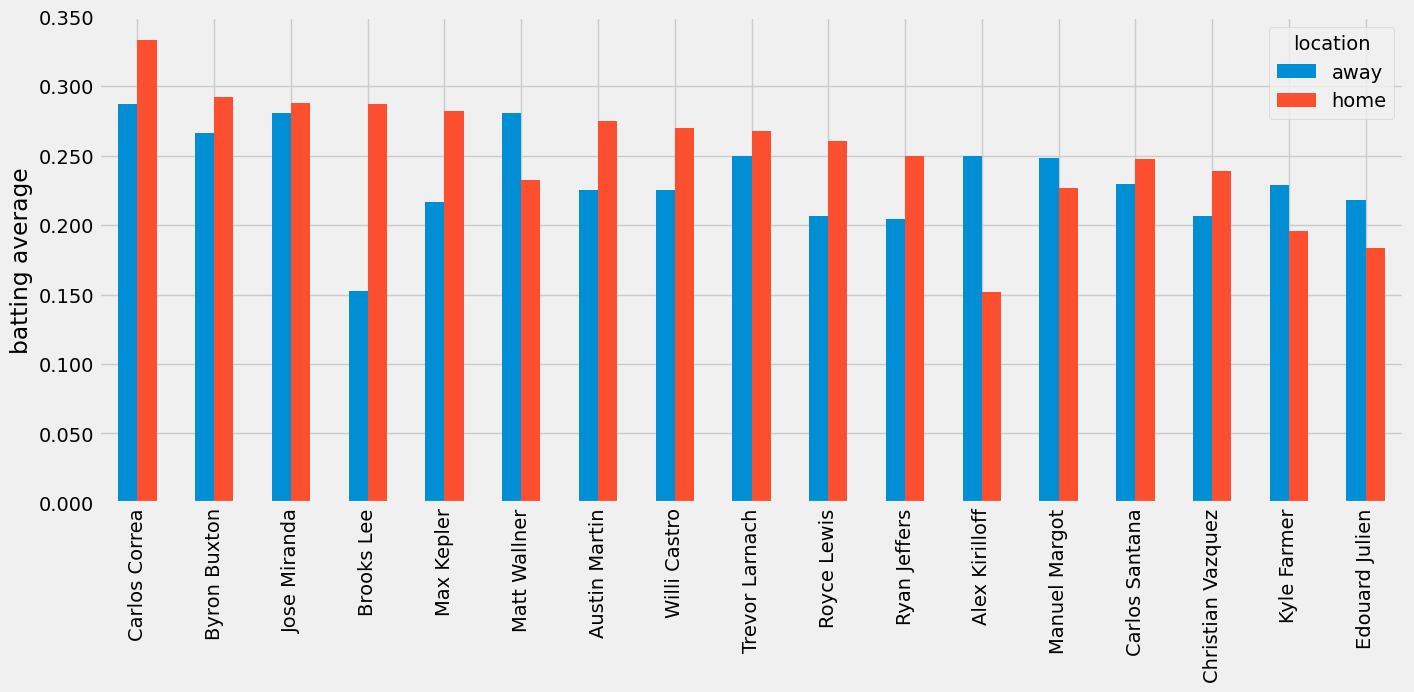

In [306]:
# a visual of batting averages for 17 players and how they vary between home and away at-bats

batting_avg_filt.unstack('location').plot(kind = 'bar', ylabel = 'batting average', xlabel = '').yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [307]:
# it's also nice to see the numbers printed out, which makes it easy to check my math against published stats (these match)
round(batting_avg_filt.unstack('location'), 3)

location,away,home
full_name,,
Carlos Correa,0.288,0.333
Byron Buxton,0.266,0.292
Jose Miranda,0.281,0.288
Brooks Lee,0.153,0.287
Max Kepler,0.217,0.282
Matt Wallner,0.281,0.232
Austin Martin,0.225,0.275
Willi Castro,0.225,0.270
Trevor Larnach,0.250,0.268


<Axes: ylabel='Density'>

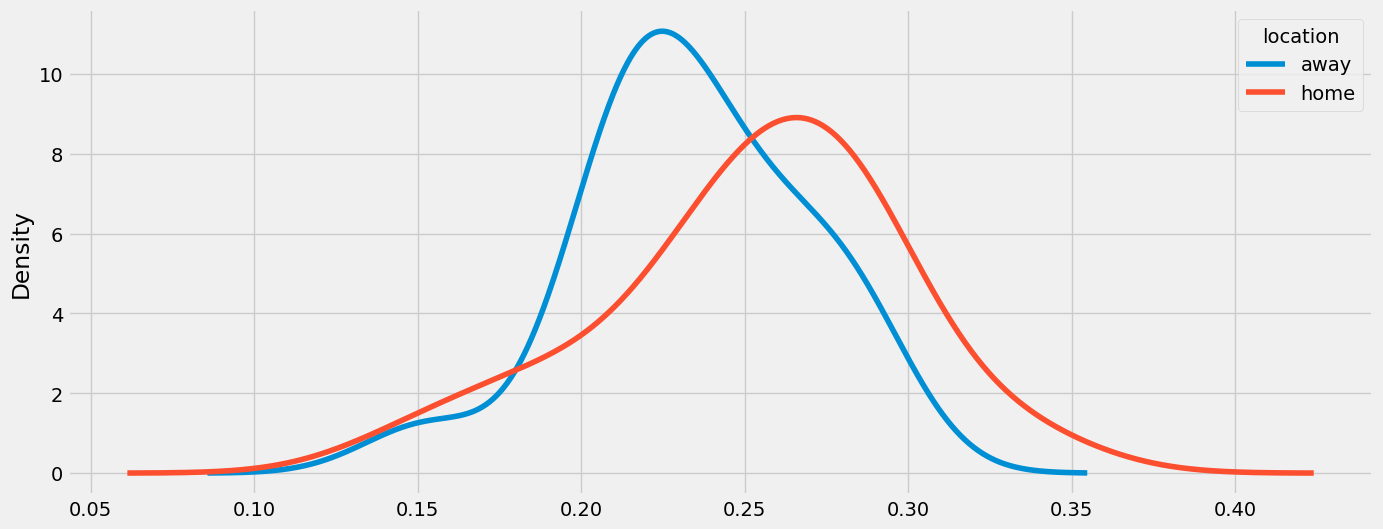

In [308]:
# a quick look at a probability density function just to get an idea of how the home vs away batting averages are distributed
batting_avg_filt.unstack('location').plot(kind = 'density', bw_method=None, ind=None)

In [309]:
# split the data by home and away
twins_home = bat_twins[bat_twins['location']=='home']
twins_away = bat_twins[bat_twins['location']=='away']

In [310]:
# cumulative batting averages for home, away, and overall
twins_home_ba = round((twins_home['hits'].sum())/(twins_home['ab'].sum()), 3)
twins_away_ba = round((twins_away['hits'].sum())/(twins_away['ab'].sum()),3)
twins_total_ba = round((bat_twins['hits'].sum())/(bat_twins['ab'].sum()),3)

In [311]:
# print the results 
print(f'Twins Overall Batting Average: {twins_total_ba}')
print(f'Twins Home Batting Average: {twins_home_ba}')
print(f'Twins Away Batting Average: {twins_away_ba}')
print(f'Twins Home Batting Average Lift %: {round((twins_home_ba/twins_total_ba-1)*100,1)}%')
print(f'Twins Away Batting Average Lift %: {round((twins_away_ba/twins_total_ba-1)*100,1)}%')

Twins Overall Batting Average: 0.246
Twins Home Batting Average: 0.257
Twins Away Batting Average: 0.236
Twins Home Batting Average Lift %: 4.5%
Twins Away Batting Average Lift %: -4.1%


In [312]:
# creating a new dataframe that just focuses on hits and at bats
player_batting = pd.merge(player_hits.unstack('location'), player_at_bats.unstack('location'), how = 'left', on = 'full_name')
player_batting.rename(columns={'away_x':'away_hits', 'home_x':'home_hits', 'away_y':'away_ab', 'home_y':'home_ab'},inplace=True)

In [313]:
# again excluding players with 20 or fewer at-bats
filt_ab2 = ((player_batting['away_ab'] + player_batting['home_ab'])>20)

In [314]:
player_batting = player_batting[filt_ab2]

In [315]:
player_batting

location,away_hits,home_hits,away_ab,home_ab
full_name,,,,
Alex Kirilloff,20,12,80,79
Austin Martin,23,36,102,131
Brooks Lee,13,25,85,87
Byron Buxton,49,50,184,171
Carlos Correa,46,53,160,159
Carlos Santana,64,60,279,242
Christian Vazquez,33,32,160,134
Edouard Julien,26,27,119,147
Jose Miranda,59,55,210,191


For a first look at statistical analysis, consider a Chi-Squared test. Think of each at-bat as having a binary outcome, either success (a hit) or a failure (an out or 'nonhit'). This formulation makes a hit (or nonhit) into a categorical variable. Note that in baseball terminology, other plate appearance outcomes such as getting on base by a walk or by getting hit by the pitch are not considered at-bats. The only possible outcomes of an at-bat are a hit or a nonhit (out). This is analagous to a shopper interacting with an e-commerce platform and either converting the interation to a purchase, or not.

In [316]:
# some aggregations to populate a contingency table for the chi-squared test. The top row in the 2x2 table is the "control" (hits and nonhits 
# during away game at-bats) and the bottom row is the experimental variable (hits and nonhits during home game at-bats).

total_hits_away = player_batting['away_hits'].sum()
total_hits_home = player_batting['home_hits'].sum()
total_nonhits_away = player_batting['away_ab'].sum() - player_batting['away_hits'].sum()
total_nonhits_home = player_batting['home_ab'].sum() - player_batting['home_hits'].sum()
contingency_table_team = np.array([[total_hits_away, total_nonhits_away],[total_hits_home, total_nonhits_home]])

contingency_table_team

array([[ 654, 2121],
       [ 691, 1989]], dtype=int64)

In [317]:
# using the scipy module to compute the pertinent statistics chi-squared and p
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table_team, correction = False)
chi2, p_value

(3.603907489807183, 0.057643932098519535)

For a chi-squared test, the null hypothesis is that the two variables (location and hits) are not related. Standard practice is to reject the null hypothesis when p < 0.05. In "simple" terms, p < 0.05 means that a chi-squared of 3.60 (or larger) has less than a 5% probability of happening by chance. In this case, p ~ 5.8%, which is just a little too high to reject the null according to the usual upper bound of of 5%. In any case, what would it mean in practical terms to reject (or accept) the null? To "fail to reject" the null in this example means that we can't say that "home-field advantage" in terms of hit-production by batters is statistically significant to a 95% level of confidence. To reject the null means that we DO believe that "home-field advantage" in terms of hit-production by batters is statistically significant to a 95% level of confidence. This kind of language is difficult to grasp even for a person who knows some statistics, to say nothing of a layperson who's just trying to understand the extent to which home-field advantage is real for batters. To muddy the waters even more, the result here of 5.8% is right on the line between rejecting and accepting the null. The home-field advantage appears to have some effect, but we'd be hard-pressed to quantify it with confidence based on this type of analysis. 

Bayesian analysis can be used to shed more light on this issue. I'll show one such formulation below.

In [430]:
# Step 1 - Determine a prior distribution of batting averages. I might collect data from a previous year, but for simplicity, I'm using 
# the first 8 weeks of the 2024 season.
# Because I filtered to just lines that show an at-bat, batting average can be easily computed as the mean of the 'hits' column
prior_weeks = 7
first_weeks_home = (bat_twins['week_number'] <= prior_weeks) & (bat_twins['location'] == 'home') & (bat_twins['ab'] == 1)
first_weeks_away = (bat_twins['week_number'] <= prior_weeks) & (bat_twins['location'] == 'away') & (bat_twins['ab'] == 1)

prior_home = bat_twins[first_weeks_home]
prior_away = bat_twins[first_weeks_away]


In [429]:
# Designate 'away' as the control group, and create a prior distribution - again, the mean of 'hits' is a batting average
prior_means = []
for i in range(1000):
    prior_means.append(prior_away.sample(500)['hits'].mean())


In [376]:
# Gut check for reasonable values
prior_means[:10]

[0.248, 0.26, 0.246, 0.25, 0.244, 0.232, 0.248, 0.22, 0.24, 0.266]

In [377]:
# model as a beta distribution
prior_alpha, prior_beta, _, _ = stats.beta.fit(prior_means, floc = 0, fscale = 1)
prior_alpha, prior_beta #these change slightly each time the prior_means distribution is sampled above

(306.87537528805785, 954.0776448005738)

In [431]:
# Calculate Home and Away Batting Averages for the Test Window (after the prior)
test_weeks = 6 # number of weeks AFTER the prior control period
# test weeks can be increased to see the model gain more "confidence" with added data
num_weeks = prior_weeks + test_weeks
data_window = bat_twins[(bat_twins['week_number'] > prior_weeks) & (bat_twins['week_number'] <= num_weeks)]
data_away = data_window[data_window['location']=='away']
data_home = data_window[data_window['location']=='home']

away_ba = round(data_away['hits'].mean(), 3)
home_ba = round(data_home['hits'].mean(), 3)
home_advantage = round(home_ba - away_ba, 3)

print(f'Away Batting Average: {away_ba}')
print(f'Home Batting Average: {home_ba}')
print(f'Home BA Advantage: {home_advantage}')

Away Batting Average: 0.214
Home Batting Average: 0.28
Home BA Advantage: 0.066


In [434]:
# these counts of hits and outs are used to update the alpha and beta posteriors
data_hits_away = data_away['hits'].sum()
data_hits_home = data_home['hits'].sum()
data_outs_away = data_away['ab'].sum() - data_away['hits'].sum()
data_outs_home = data_home['ab'].sum() - data_home['hits'].sum()

# update prior parameters based on new data
posterior_away = stats.beta(prior_alpha + data_hits_away, prior_beta + data_outs_away)
posterior_home = stats.beta(prior_alpha + data_hits_home, prior_beta + data_outs_home)

# Sample posteriors
away_samples = posterior_away.rvs(1000)
home_samples = posterior_home.rvs(1000)

#calculate probability that there is a home field advantage from the samples previously generated
prob = np.mean(home_samples > away_samples) # this is the mean of booleans (0 and 1), which is a probability
home_field_advantage = (home_samples - away_samples)/away_samples
hfa = 5 # specify a % level of home field advanatage to check in the print statement below

# Print probability and even make statements about the probability of the advantage being different values
print(f'Probability that Home BA is > Away BA: {round(prob*100)}%')
print(f'Probability that Home Field Batting Advantage is at least {hfa}%: {round(np.mean((100*home_field_advantage)>hfa)*100)}%')

Probability that Home BA is > Away BA: 97%
Probability that Home Field Batting Advantage is at least 5%: 83%


The Bayesian method fitting the beta distribution gives a more relatable result. We can fiddle with different values of the home field advantage (hfa) to see the likelihood that it the specified hfa is supported by the data. For example, after 6 weeks of posterior data updates, a 1% advantage is 97% likely, a 5% advantage is 82% likely, a 10% advantage is 54% likely, and a 50% advantage is 0% likely. 

Of course, the main point here isn't to delve into baseball statistics. This method can easily be adapted to solving business problems or answering other real-world questions. Can we quantify the degree to which one advertisement delivered more engagement or purchases than another? Can we quantify the degree to which a product sells better to one customer segment than to another customer segment? The possibilities are endless. 

Here is a further explanation of Bayesian methods [applied to baseball](http://varianceexplained.org/statistics/beta_distribution_and_baseball/).